In [221]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import constants
import itertools
import skrf as rf

%config InlineBackend.figure_format = 'svg'
plt.rcParams['lines.linewidth'] = 0.8

In [222]:
fstart = -3
fstop = 40
fpoints = 100

f = np.logspace(fstart, fstop, fpoints)

## Define parameters in RLGCK Model

In [223]:
L = 1e-7
Cm1 = 3e-9
Cm2 = 3e-10
Ca = 3e-20

# Assume negligible looses
R = 1e-4
Gm = 1e-4
Ga = 1e-6

In [224]:
num_of_sections = 8
num_of_combinations = 2**num_of_sections

# Generate all possible combinations of an 8-bit input
input_combinations = list(itertools.product([0, 1], repeat=8))

# Convert the combinations to a NumPy array
input_matrix = np.array(input_combinations)

Cm = input_matrix*Cm1 + (1-input_matrix)*Cm2 # capacitance values for every single state

Interest - Odd mode

In [225]:
# Define odd and even mode parameters

def odd_mode_params(f, L, Cm, Ca, Gm, Ga):
    w = 2*np.pi*f
    Co = 2*Cm - Ca
    Go = 2*Gm + Ga
    Lo = L*(1-1e-3)
    Ro = R
    gamma_o = 1j*(2*np.pi*np.sqrt(Lo*Co))
    Z0o = np.sqrt((Ro+1j*w*Lo)/(Go + 1j*w*Co))

    f0_o = 1/(2*np.pi*np.sqrt(Lo/Co)) # frequency at which the coupled lines are a quarter-wavelength long electrically when excited in the odd mode
    theta_o = (np.pi/2)*(f/f0_o)

    return Lo, Co, Go, Ro, gamma_o, Z0o, theta_o

def even_mode_params(f, L, Cm, Ca, Gm, Ga):
    w = 2*np.pi*f
    Ce = Ca
    Ge = Ga
    Le = L*(1+1e-3)
    Re = R
    gamma_e = 1j*(2*np.pi*w*np.sqrt(Le*Ce))
    Z0e = np.sqrt((Re+1j*w*Le)/(Ge + 1j*w*Ce))

    f0_e = 1/(2*np.pi*np.sqrt(Le/Ce)) #frequency at which the coupled lines are a quarter-wavelength long electrically when excited in the even mode,
    theta_e = (np.pi/2)*(f/f0_e)

    return Le, Ce, Ge, Re, gamma_e, Z0e, theta_e

In [226]:
Lo, Co, Go, Ro, gamma_o, Z0o, theta_o = odd_mode_params(f, L, Cm[num_of_combinations-1][0], Ca, Gm, Ga)
Le, Ce, Ge, Re, gamma_e, Z0e, theta_e = even_mode_params(f, L, Cm[num_of_combinations-1][0], Ca, Gm, Ga)

Y0e = 1/(Z0e)
Y0o = 1/(Z0o)

The following functions translate ABCD matrices to S-parameters for complex load and source impedances

In [227]:
# Paper - https://www.researchgate.net/publication/3118645_Conversions_Between_S_Z_Y_h_ABCD_and_T_Parameters_which_are_Valid_for_Complex_Source_and_Load_Impedances/figures?lo=1

# Z01 - Source impedance
# Z02 - Load impedance
# the impedances will be measured from the connected ends in the multi-port system, as shown in Pozar on page 429 Table 8.8
def abcd2s(A, B, C, D, Z01, Z02):
    R01 = np.real(Z01)
    R02 = np.real(Z02)

    An = (A*Z02)/(np.sqrt(R01*R02))
    Bn = B/(np.sqrt(R01*R02))
    Cn = (C*Z01*Z02)/(np.sqrt(R01*R02))
    Dn = (D*Z01)/(np.sqrt(R01*R02))

    sum = An + Bn + Cn + Dn

    S11 = (An + Bn - C*(np.conj(Z01)/Z01) - Dn*(np.conj(Z01)/Z01))/sum
    S12 = 2*(A*D - B*C)/sum
    S21 = 2/sum
    S22 = (-An*(np.conj(Z02)/Z02) + Bn - Cn*(np.conj(Z02/Z02) + Dn))/sum
           
    return S11, S12, S21, S22

In [228]:
def plot_ABCD(f, A, B, C, D):
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 10))
    ax.flat[0].semilogx(f, 20 * np.log10(np.abs(A)))
    ax.flat[0].set_xlabel("f")
    ax.flat[0].set_ylabel("$20 \cdot \log_{10}(A)$")
    ax.flat[0].grid(True)  # Add grid lines

    ax.flat[1].semilogx(f, 20 * np.log10(np.abs(B)))
    ax.flat[1].set_xlabel("f")
    ax.flat[1].set_ylabel("$20 \cdot \log_{10}(B)$")
    ax.flat[1].grid(True)  # Add grid lines

    ax.flat[2].semilogx(f, 20 * np.log10(np.abs(C)))
    ax.flat[2].set_xlabel("f")
    ax.flat[2].set_ylabel("$20 \cdot \log_{10}(C)$")
    ax.flat[2].grid(True)  # Add grid lines

    ax.flat[3].semilogx(f, 20 * np.log10(np.abs(D)))
    ax.flat[3].set_xlabel("f")
    ax.flat[3].set_ylabel("$20 \cdot \log_{10}(D)$")
    ax.flat[3].grid(True)  # Add grid lines

    plt.show()

In [229]:
def plot_S_params(f, S11, S12, S21, S22):
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 10))
    ax.flat[0].semilogx(f, 20*np.log10(np.abs(S11)))
    ax.flat[0].set_xlabel("f")
    ax.flat[0].set_ylabel("$S_{11}$")
    ax.flat[0].grid(True)  # Add grid lines

    ax.flat[1].semilogx(f, 20*np.log10(np.abs(S12)))
    ax.flat[1].set_xlabel("f")
    ax.flat[1].set_ylabel("$S_{12}$")
    ax.flat[1].grid(True)  # Add grid lines

    ax.flat[2].semilogx(f, 20*np.log10(np.abs(S21)))
    ax.flat[2].set_xlabel("f")
    ax.flat[2].set_ylabel("$S_{21}$")
    ax.flat[2].grid(True)  # Add grid lines

    ax.flat[3].semilogx(f, 20*np.log10(np.abs(S22)))
    ax.flat[3].set_xlabel("f")
    ax.flat[3].set_ylabel("$S_{22}$")
    ax.flat[3].grid(True)  # Add grid lines
    plt.show()

## Filter Simulations 

We use the parameters we have to simulate 2 canonical forms of parallely coupled transmission line.  
Ecah of these has a relisation is termsn of S-parameters (lowpass or bandpass)

### Realisation 1 from Table 8.8 in Pozar

For one section with switch open

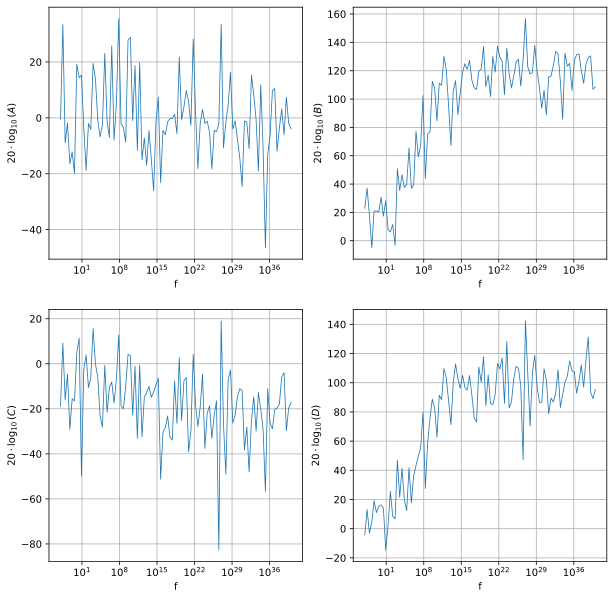

In [230]:
# coresponding ABCD matix for realisation 1

A = (2*np.cos(theta_o)*np.cos(theta_e))/(np.cos(theta_o) + np.cos(theta_e))
B = 1j*( (Z0o*np.sin(theta_o)*np.cos(theta_e) + Z0e*np.cos(theta_o)*np.sin(theta_e))/(np.cos(theta_o) + np.cos(theta_e)) )
C = 1j*( (Y0o*np.sin(theta_o)*np.cos(theta_e) + Y0e*np.cos(theta_o)*np.sin(theta_e))/(np.cos(theta_o) + np.cos(theta_e)) )
D = (2*(np.cos(theta_o)*np.cos(theta_e) + 1) - np.sin(theta_o)*np.sin(theta_e)*(Y0o*Z0e+Z0o*Y0e))/(2*(np.cos(theta_o) + np.cos(theta_e)))

plot_ABCD(f, A, B, C, D)

In [231]:
Z01 = 50
Z02 = 50

# Create a scikit-rf Network object from the ABCD matrix for the entire frequency range
ABCD_matrix = np.array([[A, B], [C, D]])
network = rf.Network(type='ABCD', z0=[Z0o, Z0e], f=f, s=rf.a2s(ABCD_matrix, z0=[Z0o, Z0e]))

IndexError: abcd parameters are defined for 2-ports networks only

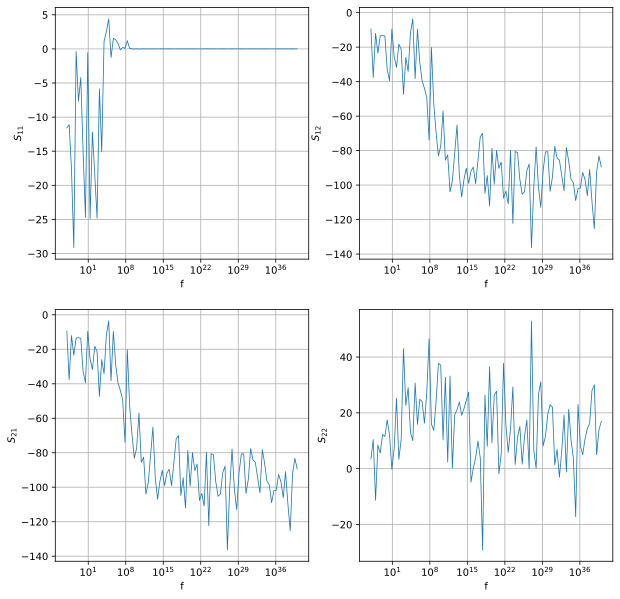

In [ ]:
S11, S12, S21, S22 = abcd2s(A, B, C, D, Z01, Z02)
plot_S_params(f, S11, S12, S21, S22)

For the complete line

1. Start from the load
2. Find ABCD matrix for a part of TL with constant $Z_c$
3. Find Z01 and Z02 for this part
3. Convert ABCD to S-parameters
4. Keep multiplying S-matrix

In [ ]:
def matmul(A11, A12, A21, A22, B11, B12, B21, B22):
    # Perform matrix multiplication
    C11 = A11 * B11 + A12 * B21
    C12 = A11 * B12 + A12 * B22
    C21 = A21 * B11 + A22 * B21
    C22 = A21 * B12 + A22 * B22
    
    return C11, C12, C21, C22

def find_Z01_Z02(Z01, Z02):
    pass

### Realisation 2 from Table 8.8 in Pozar

For one section with switch open

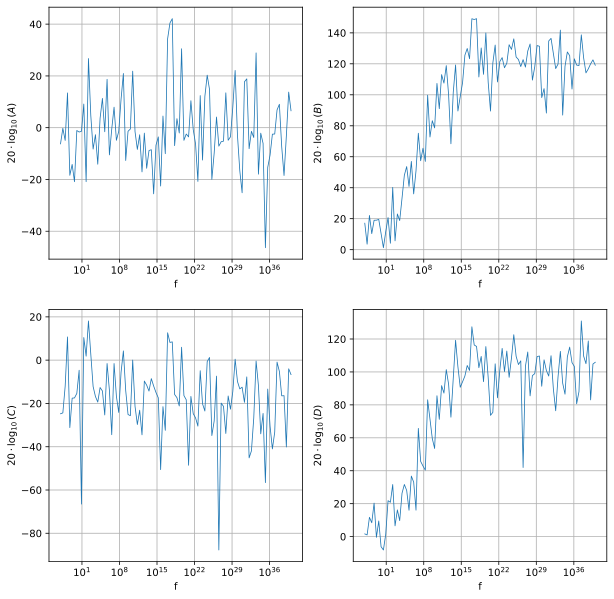

In [ ]:
# coresponding ABCD matix for realisation 2

A = (2*np.cos(theta_o)*np.cos(theta_e))/(np.cos(theta_o) - np.cos(theta_e))
B = 1j*( (Z0o*np.sin(theta_o)*np.cos(theta_e) + Z0e*np.cos(theta_o)*np.sin(theta_e))/(np.cos(theta_o) - np.cos(theta_e)) )
C = 1j*( (Y0o*np.sin(theta_o)*np.cos(theta_e) + Y0e*np.cos(theta_o)*np.sin(theta_e))/(np.cos(theta_o) - np.cos(theta_e)) )
D = (2*(np.cos(theta_o)*np.cos(theta_e) - 1) - np.sin(theta_o)*np.sin(theta_e)*(Y0o*Z0e+Z0o*Y0e))/(2*(np.cos(theta_o) - np.cos(theta_e)))

plot_ABCD(f, A, B, C, D)

In [ ]:
Z01 = 50
Z02 = 50

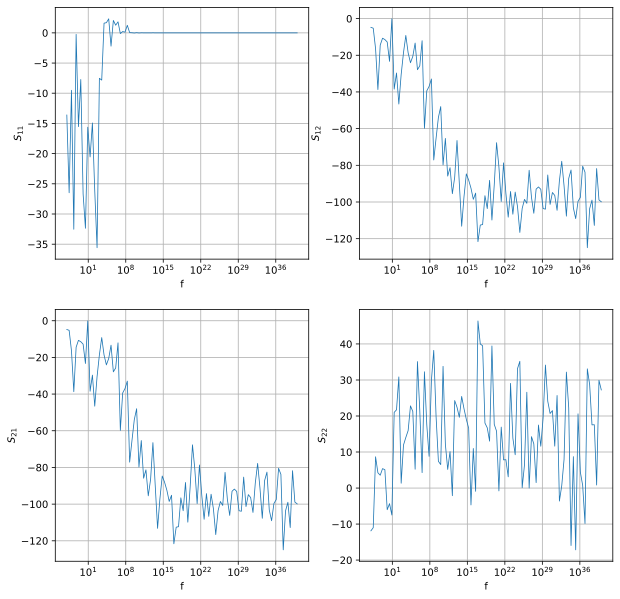

In [ ]:
S11, S12, S21, S22 = abcd2s(A, B, C, D, Z01, Z02)
plot_S_params(f, S11, S12, S21, S22)

---

### Realisation 3 from Table 8.8 in Pozar

For one section with switch open

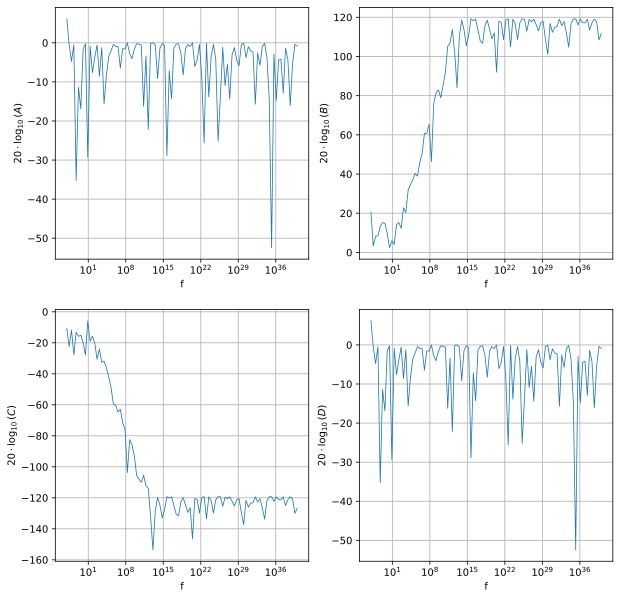

In [ ]:
A = (Z0e*(1/np.tan(theta_e)) + Z0o*(1/np.tan(theta_o))) / (Z0e*(1/np.sin(theta_e)) - Z0o*(1/np.sin(theta_o)))
B = 1j/2 * (Z0e**2 + Z0o**2 - 2*Z0e*Z0o*(1/np.tan(theta_e)*1/np.tan(theta_o) + 1/np.sin(theta_e)*1/np.sin(theta_o))) / (Z0e*(1/np.sin(theta_e)) - Z0o*(1/np.sin(theta_o)))
C = 2*1j / (Z0e*(1/np.sin(theta_e)) - Z0o*(1/np.sin(theta_o)))
D = A

plot_ABCD(f, A, B, C, D)

In [ ]:
Z01 = 50
Z02 = 50

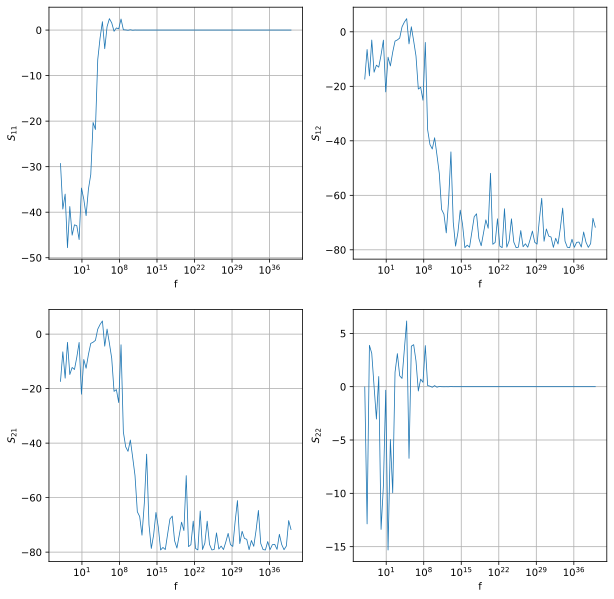

In [ ]:
S11, S12, S21, S22 = abcd2s(A, B, C, D, Z01, Z02)
plot_S_params(f, S11, S12, S21, S22)

In [232]:
import numpy as np

def reduce_system(A, V, I):
    # Extract A_red (2x2 matrix)
    A_red = A[np.ix_([0, 3], [0, 3])]

    return A_red

# Example usage:
A = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

V = np.array([1, 0, 1, 1])
I = np.array([1, 1, 0, 1])

A_red = reduce_system(A, V, I)
print("A_red:")
print(A_red)


A_red:
[[1 0]
 [0 1]]
